# Анализ влияния индекса страха и жадности (Fear & Greed Index) на цену криптовалюты Bitcoin

# Содержание

* [1. Описание задачи](#0)
* [2. Установка инструментов](#1)
    * [2.1 Список пакетов Python](#1.1)
    * [2.2 Импорт пакетов](#1.2)
* [3. Загрузка данных](#2)
* [4. Предварительная обработка данных](#3)
    * [4.1 Объединение данных в один DataFrame](#3.1)
* [5. Первичный анализ](#4)
    * [5.1 Анализ распредления цены и индекса](#4.1)
    * [5.2 Оценка корреляции](#4.2)
    * [5.3 Промежуточные выводы](#4.3)
* [6. Оценка показателя рентабельности инвестиций ROI. Проверка гипотезы](#5)
    * [6.1 Расчет показателя](#5.1)
    * [6.2 Анализ результата рассчета](#5.2)
* [7. Выводы](#6)



<a id='0'></a>
# Часть 1. Описание задачи

В данном отчете попробуем оценить влияние достаточно интересного индекса страха и жадности (Fear & Greed Index) на движение цены самой популярной криптовалюты Bitcoin. Оценим корреляцию и узнаем можно ли полагаться на индекс для среднесрочных инвестиций.

Для чего же вообще измеряется индекс страха и жадности?
Поведение криптовалютного рынка очень эмоционально. Люди склонны к жадности, когда рынок растёт, что приводит к FOMO (страху упустить возможность). Кроме того, люди часто продают свои монеты в иррациональной реакции на увиденные низкие показатели. Здесь есть два простых предположения:

* Чрезмерный страх может быть признаком того, что инвесторы слишком обеспокоены. Это может быть возможностью для покупки.
* Когда инвесторы становятся слишком жадными, это означает, что рынок ожидает коррекция.

Показатель индекса варьируется от 0 до 100. Ноль означает «Чрезмерный страх», а 100 — «Чрезмерная жадность».

Индекс строится из нескольких состовляющих:
* **Волатильность (25 %)**
Измерение текущей волатильности и максимальные просадки биткоина и сравниваем их с соответствующими средними значениями за последние 30 и 90 дней.

* **Импульс/Объем рынка (25 %)**
Измерение текущего объем и импульса рынка (опять же, в сравнении со средними значениями за последние 30/90 дней) и объединение эти двух показателей. Как правило, когда наблюдаются высокие объемы покупок на позитивном рынке ежедневно, делается вывод, что рынок ведет себя чрезмерно жадно / слишком оптимистично.

* **Социальные сети (15 %)**
Собираются и подсчитываюся посты по различным хэштегам в соцсетях и проверяются, как быстро и сколько взаимодействий они получают за определенные промежутки времени. Необычно высокий уровень взаимодействия приводит к росту общественного интереса, что может соответствовать жадному поведению рынка.

* **Опросы (15%)**
Проведение еженедельных опросов и опрос людей, как они видят рынок. По ним получают представления о настроениях групп инвесторов.

* **Доминирование (10%)**
Доминирование монеты отражает долю рыночной капитализации всего криптовалютного рынка. В частности, что касается Биткоина, рост его доминирования вызван страхом перед (и, следовательно, сокращением) слишком спекулятивными инвестициями в альткоины, поскольку Биткоин все больше становится безопасным убежищем для криптовалют. С другой стороны, когда доминирование Биткоина сокращается, люди становятся более жадными, инвестируя в более рискованные альткоины, мечтая о своем шансе в следующем крупном бычьем ралли. Анализируя доминирование другой монеты, помимо Биткоина, можно утверждать обратное, поскольку больший интерес к альткоину может свидетельствовать о бычьем/жадном поведении по отношению к этой конкретной монете.

* **Тренды (10%)**
Собираются  и анализируются данные Google Trends по различным поисковым запросам, связанным с Биткоином, особенно изменение объемов поиска, а также рекомендуемые другие популярные в настоящее время запросы. Например, если мы проверим Google Trends по запросу «Биткоин», мы не получим много информации из объема поиска. Однако в настоящее время мы можем видеть рост запроса «манипулирование ценой биткоина» на +1550% в блоке связанных поисковых запросов. Это явный признак страха на рынке.

В данном отчете будем анализировать временной ряд за 2024 и неполный 2025 год

Данные, которые мы будем использовать, получены из API криптовалютной биржи Binance и API Alternative.me. Данные содержат цены открытия, максимальные, минимальные и закрытия, объем торгов, а так же значение показателя индекса.

<a id='1'></a>
# Часть 2. Загрузка пакетов

<a id='1.1'></a>
## 2.1. Перечень пакетов, которые мы будем использовать в данном отчете
* pandas
* numpy 
* scipy
* matplotlib
* requests
* pybit - API биржи Binance

<a id='1.2'></a>
## 2.2. Импорт пакетов

In [337]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from dotenv import load_dotenv
from datetime import datetime, timedelta
from pybit.unified_trading import HTTP
from scipy import stats
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator


%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

load_dotenv()

# Создадим экземпляр класса API биржи и зададим нужные глобальные переменные для работы с другими источниками данных
session = HTTP(testnet=False)
# URL_1 = 'https://pro-api.coinmarketcap.com/v3/fear-and-greed/historical'
URL = 'https://api.alternative.me/fng/'
SYMBOL = 'BTCUSDT'
# 
# API_KEY = os.getenv('API_SECRET')


<a id='2'></a>
# Часть 3. Загрузка данных
* API биржи Binance очень функционален и предоставляет много различных данных о криптовалютах. В данном случае нас интересуют данные OHLC (данные цены) по криптовалюте Bitcoin.

* API Alternative.me предоставляет данные по индексу страха и жадности


In [347]:
START_DATE_24 = '2024-01-01'
END_DATE_24 = '2025-01-02'
START_DATE_25 = '2025-01-01'
END_DATE_25 = '2025-12-16'


# Загружаем данные
def extract_data(session=session, date_start=None, date_end=None, url=URL, symbol=SYMBOL):
    ''' Функция получает данные цен с биржи и данные индекса
    Необходимо указывать конечную дату на 1 день больше, так как данные по закрытию 
    приходят в 03:00 АМ на сл.день
    Параметры:
    - session: объект сессии API Binance
    - date_start: начальная дата (str в формате 'YYYY-MM-DD')
    - date_end: конечная дата (str в формате 'YYYY-MM-DD')
    - url: URL API 
    - symbol: тикер актива'''

    # Переводим даты в timestamp(ms) для корректного получения данных с биржи
    start = int(datetime.strptime(date_start, '%Y-%m-%d').timestamp() * 1000)
    end = int(datetime.strptime(date_end, '%Y-%m-%d').timestamp() * 1000)

    response_exchange = session.get_kline(
        category='inverse',
        symbol=symbol,
        interval='D',
        start=start,
        end=end,
        limit=367
    )

    params = {
        'limit': 0
    }
    response_index = requests.get(url, params=params).json()

    return response_exchange['result']['list'], response_index['data']

data_2025, index_2025 = extract_data(date_start=START_DATE_25, date_end=END_DATE_25)
data_2024, index_2024 = extract_data(date_start=START_DATE_24, date_end=END_DATE_24)
data_2024, index_2024

([['1735689600000',
   '93530',
   '95158.4',
   '92840',
   '94564.6',
   '46830.37',
   '4399935460.3038'],
  ['1735603200000',
   '92739.3',
   '96322.1',
   '91981.4',
   '93530',
   '98560.554',
   '9282689586.2034'],
  ['1735516800000',
   '93699',
   '95000',
   '91463.7',
   '92739.3',
   '128458.068',
   '11959785141.1981'],
  ['1735430400000',
   '95255.8',
   '95300',
   '92926.7',
   '93699',
   '50241.219',
   '4730768959.8991'],
  ['1735344000000',
   '94251',
   '95699.9',
   '94070.2',
   '95255.8',
   '36894.789',
   '3495950021.5171'],
  ['1735257600000',
   '95743.2',
   '97500',
   '93380.1',
   '94251',
   '103774.46',
   '9901230580.6281'],
  ['1735171200000',
   '99405.2',
   '99950',
   '95137.5',
   '95743.2',
   '100668.442',
   '9726514484.3588'],
  ['1735084800000',
   '98628.3',
   '99590',
   '97562.6',
   '99405.2',
   '67405.221',
   '6640188781.1755'],
  ['1734998400000',
   '94837',
   '99435.7',
   '93508.6',
   '98628.3',
   '105970.467',
   '1025052

<a id='3'></a>
# Часть 4. Предварительная обработка данных

<a id='3.1'></a>
# Часть 4.1 Объединение данных в один DataFrame
Для дальнейшей работы объединим полученные по API данные в один DataFrame

In [360]:
# Предварительная обработка данных
def transform_data(price_data: list, index_data: list):
    '''
    Преобразует и объединяет данные о ценах актива и индексные данные в структурированный DataFrame
    Параметры:
    - price_data: List 
        Массив данных цены актива
    - index_data: List 
        Массив данных по индексу
    '''
    df = pd.DataFrame(price_data, columns=['date', 'open', 'high', 'low', 'close', 'vol', 'turnover'])
    df = df.iloc[:, :6]
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index, unit='ms')
    df = df.astype('float')

    df2 = pd.DataFrame({
        'date': [i['timestamp'] for i in index_data],
        'index': [i['value'] for i in index_data]
    })
    df2.set_index('date', inplace=True)
    df2.index = pd.to_datetime(df2.index, unit='s')
    df2 = df2.astype('int')

    df3 = pd.concat([df, df2], axis=1, join='inner')
    df3.sort_index(inplace=True)

    # Добавим скользящую среднюю и скользящую медиану за 30Д
    rolling = df3['close'].rolling(30, min_periods=1)
    df3['roll_mean'] = rolling.mean().round(3)
    df3['roll_median'] = rolling.median()

    return df, df2, df3

# В БЛОК ОЦЕНКИ ROI
def find_periods(df: pd.DataFrame):
    min_index = df.loc[df['index'] < 20].sort_index()
    min_index['date_diff'] = min_index.index.diff().fillna(pd.Timedelta(days=0))

    fragments = []
    current_period = [min_index.iloc[0]]

    for i in range(1, len(min_index)):
        if min_index.iloc[i]['date_diff'] > pd.Timedelta(days=20):
            fragments.append(pd.DataFrame(current_period))
            current_period = [min_index.iloc[i]]
        else:
            current_period.append(min_index.iloc[i])
    fragments.append(pd.DataFrame(current_period))

    return fragments

periods = find_periods(total_2025)
# for i, period in enumerate(periods):
#     print(f'period {i + 1}:')
#     print(period)

# В БЛОК ОЦЕНКИ ROI


price, index, total_2025 = transform_data(data_2025, index_2025)
price, index, total_2024 = transform_data(data_2024, index_2024)

total_2024.head(20)

C:\Users\deadm\AppData\Local\Temp\ipykernel_18208\3460811886.py:14: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df.index = pd.to_datetime(df.index, unit='ms')
C:\Users\deadm\AppData\Local\Temp\ipykernel_18208\3460811886.py:22: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df2.index = pd.to_datetime(df2.index, unit='s')
C:\Users\deadm\AppData\Local\Temp\ipykernel_18208\3460811886.py:14: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In

,open,high,low,close,vol,index,roll_mean,roll_median
date,,,,,,,,
2024-01-01,42324.8,44284.9,42211.2,44235.5,79123.439,65,44235.500,44235.50
2024-01-02,44235.5,45946.5,44208.7,44989.0,180530.083,71,44612.250,44612.25
2024-01-03,44989.0,45567.8,40210.0,42871.9,308217.553,70,44032.133,44235.50
2024-01-04,42871.9,44875.5,42637.0,44156.3,164677.973,68,44063.175,44195.90
2024-01-05,44156.3,44436.4,42181.0,44156.8,194356.602,72,44081.900,44156.80
2024-01-06,44156.8,44229.4,43400.7,43972.4,54322.090,70,44063.650,44156.55
2024-01-07,43972.4,44509.6,43577.0,43936.2,73660.896,71,44045.443,44156.30
2024-01-08,43936.2,47318.3,43136.9,46972.8,228622.432,71,44411.362,44156.55
2024-01-09,46972.8,48083.4,44750.0,46128.0,237993.417,76,44602.100,44156.80


<a id='4'></a>
# Часть 5 Первичный анализ

<a id='4.1'></a>
# Часть 5.1 Анализ распределения цены и индекса
Для начала, чтобы понять какой коэфициент корреляции нам нужен, взглянем на распределение наших данных.

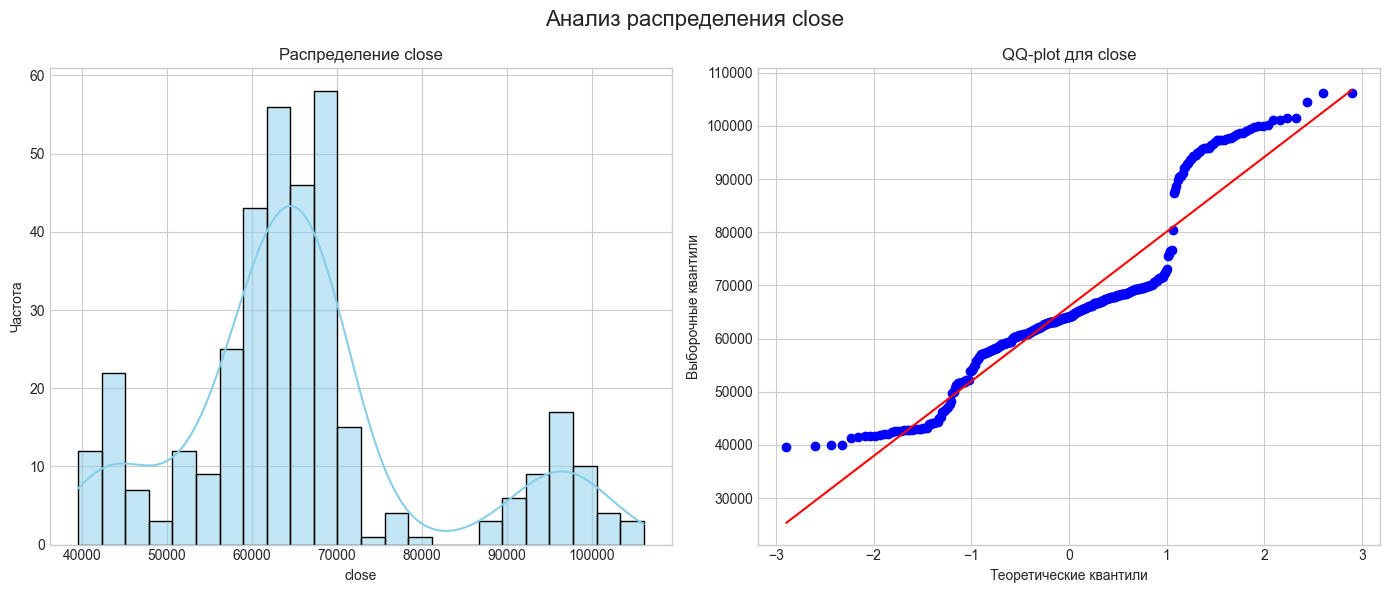

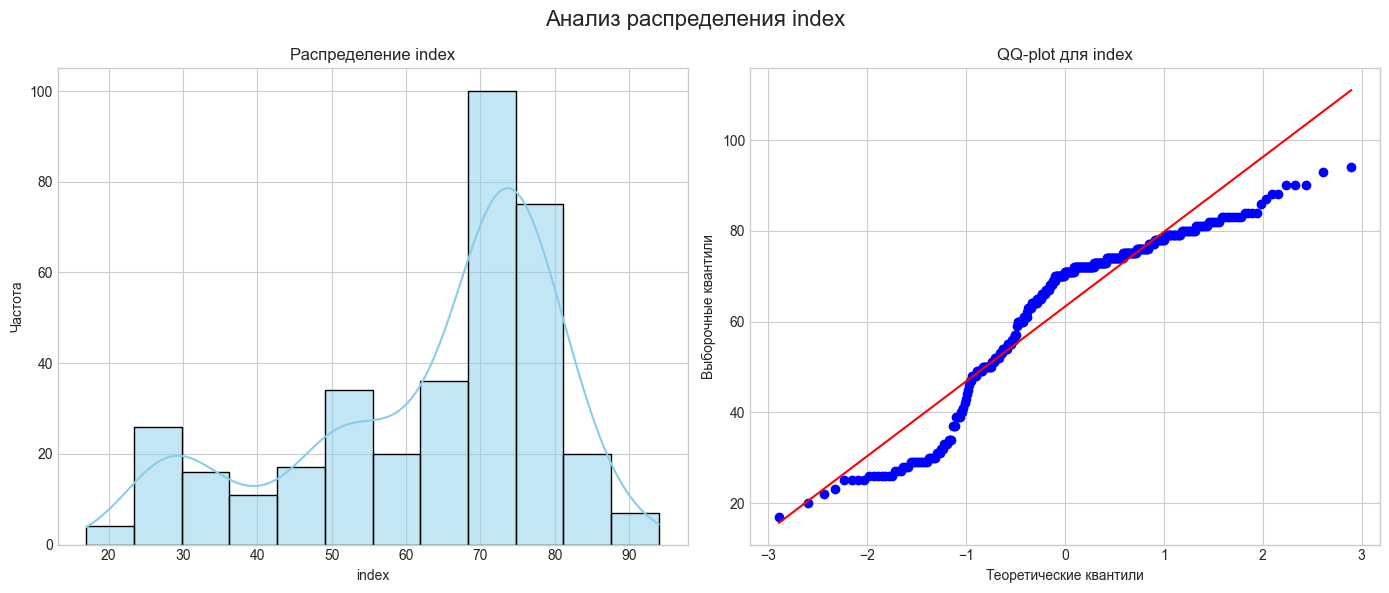

In [379]:
# Посмотрим на распределение наших целевых данных за 2024 год (цены закрытия дня и индекса)

def plot_dist(data: pd.DataFrame, column_name):
    '''
    Функция для построения графика распределения и QQ-plot
    Параметры:
    data: pd.DataFrame
        Входной датасет
    column_name: str
        название столбца для построения
    '''
    # проверка на налчие данных 
    if column_name not in data.columns:
        raise ValueError(f"столбец {column_name} не найден в данных")
    
    # Создаем фигуру
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Распределение
    sns.histplot(
        data[column_name],
        kde=True,
        ax=axes[0],
        color='skyblue',
        edgecolor='black'
    )
    axes[0].set_title(f'Распределение {column_name}')
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel('Частота')

    # QQ-plot
    stats.probplot(
        data[column_name],
        plot=axes[1]
    )
    axes[1].set_title(f'QQ-plot для {column_name}')
    axes[1].set_xlabel('Теоретические квантили')
    axes[1].set_ylabel('Выборочные квантили')

    # Настройки
    plt.suptitle(f"Анализ распределения {column_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Взгялнем на наши целевые данные
close_plot_24 = plot_dist(total_2024, 'close')
index_plot_24 = plot_dist(total_2024, 'index')

На основе данных графика можно сделать вывод, что значения close, index не подчиняются нормальному закону распределения, имеют выраженные выбросы. 

Учитывая это, будем использовать коэффициент корреляции Спирмена вместо Пирсона, т.к. он не требует нормального распределения и устойчив к выбросам.

Проверим статестическую гипотезу о наличии связи между переменными close и index с помощью коэффициента ранговой корреляции Спирмена.

Формулировка гипотез:
* **Нулевая гипотеза (H0):**
    Между close и index нет связи, коэф.корреляции равен 0
* **Альтернативная гипотеза (H1):**
    Между close и index есть связь, коэф.корреляции не равен 0

In [ ]:


# Посмотрим матрицу корреляции индекса и цены
corr_matrix = total_2024.corr()

rho, p_value = stats.spearmanr(total_2024.close, total_2024['index'])
print(f"Коэф Спирмена: (p): {rho:.3f}")
print(f"p-value: {p_value:.48f}")


# диаграмма рассеяния
# sns.scatterplot(data=total_2024, x=total_2024['index'], y=total_2024.close)
# sns.regplot(data=total_2024, x=total_2024['index'], y=total_2024.close, scatter=False, color='red')
# plt.title('Диаграмма рассеяния с линией тренда')
# plt.show()

# построим heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
# plt.tight_layout()
# plt.show()


# Гистограмма распределений цены и индекса
# plt.hist(total_2024.close, bins=20, alpha=0.5, label='Close')
# plt.hist(total_2024['index'], bins=20, alpha=0.5, label='Index')
# plt.legend()
# plt.show()


# Q-Q plot
# plt.figure(figsize=(8, 6))
# stats.probplot(total_2024['close'], dist="norm", plot=plt)
# plt.title('Q‑Q plot (проверка на нормальность)')
# plt.show()

# KDE
# plt.figure(figsize=(10, 6))
# sns.kdeplot(data=total_2025['close'], fill=True, color='blue', alpha=0.5)
# plt.title('Плотность распределения цены актива (KDE)')
# plt.xlabel('Цена')
# plt.ylabel('Плотность')
# plt.show()

# KDE + hist
# plt.figure(figsize=(10, 6))
# sns.histplot(data=total_2024['index'], kde=True, bins=10, color='lightblue', edgecolor='black')
# plt.title('Гистограмма и плотность распределения цены')
# plt.xlabel('Цена')
# plt.ylabel('Частота / Плотность')
# plt.show()

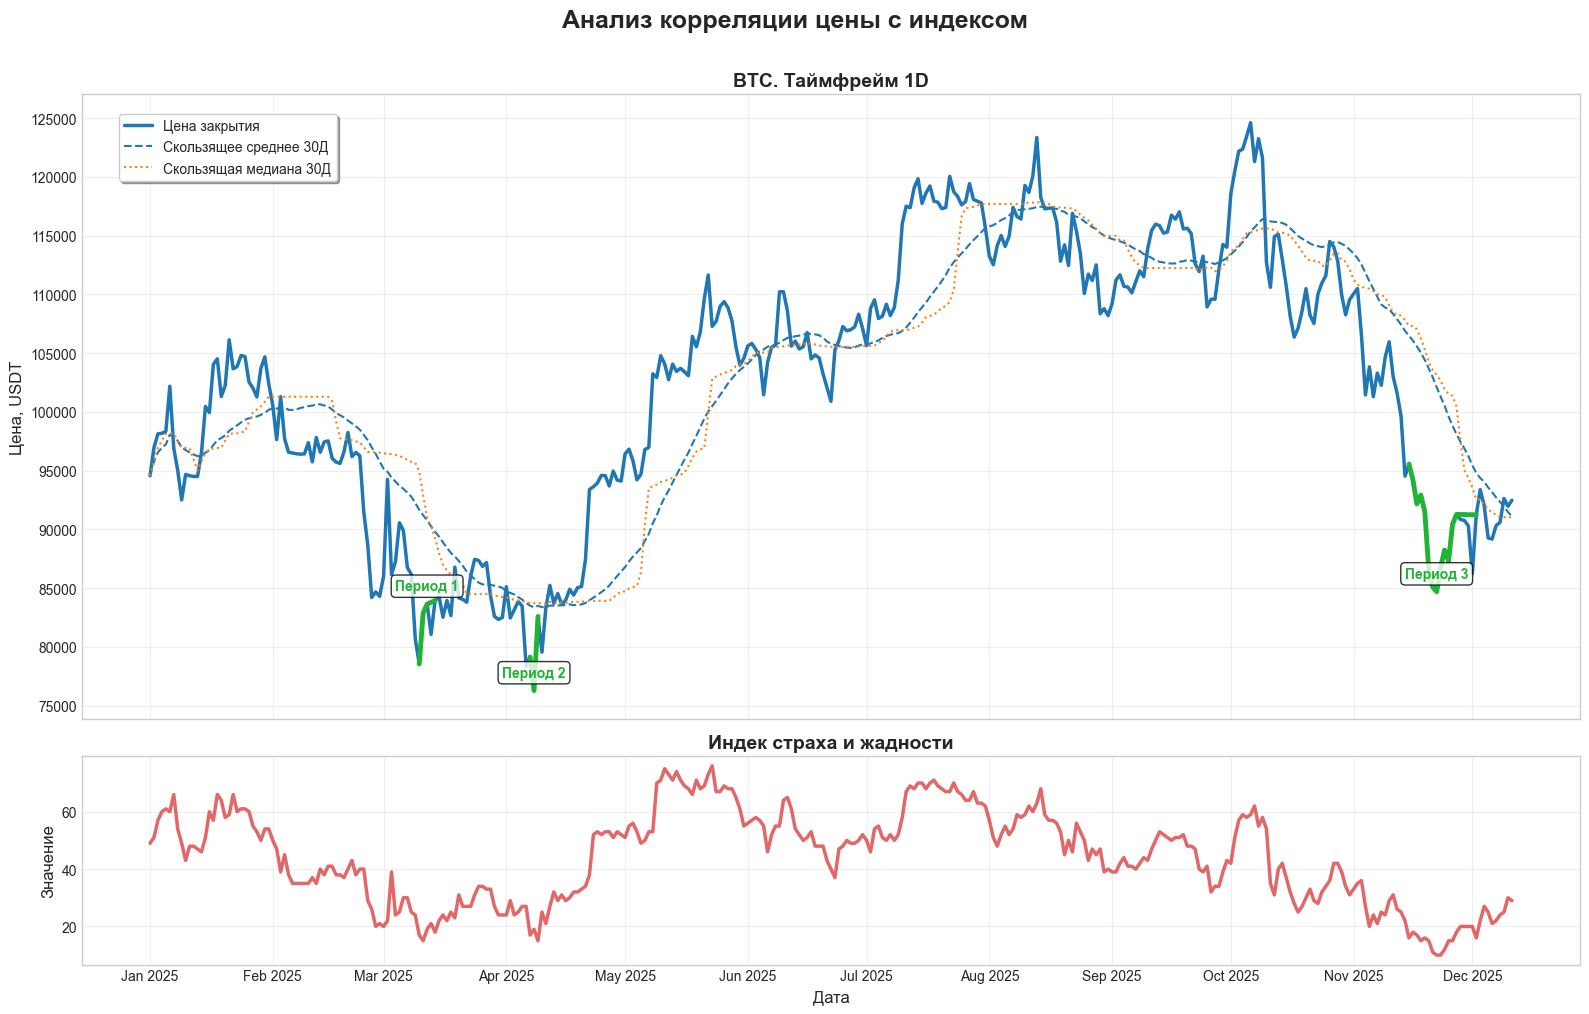

In [240]:
# Визуализируем данные
fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Верхний график — цена
ax1.plot(total_2025.index, total_2025.close, color='#1f77b4', linewidth=2.5, label='Цена закрытия')
ax1.plot(total_2025.roll_mean, linestyle='--', linewidth=1.5, label='Скользящее среднее 30Д')
ax1.plot(total_2025.roll_median, linestyle=':', linewidth=1.5, label='Скользящая медиана 30Д')
ax1.set_title('BTC. Таймфрейм 1D', fontsize=14, fontweight='bold')
ax1.set_ylabel('Цена, USDT', fontsize=12)
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.yaxis.set_major_locator(MultipleLocator(5000))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98),
          ncol=1, frameon=True, fancybox=True, shadow=True)

# Наложение периодов низкого индекса
for i, period in enumerate(periods):
    ax1.plot(period.index, period['close'], color="#1fb433", linewidth=3.5, label='Индекс < 20')
    ax1.grid(True, alpha=0.3)

    # Аннотации: подпись над каждым периодом
    mid_date = period.index[len(period) // 2]  # середина периода
    mid_price = period.iloc[len(period) // 2]['close']
    ax1.annotate(f'Период {i+1}',
                xy=(mid_date, mid_price),
                xytext=(0, 10),  # смещение вверх на 10 пунктов
                textcoords='offset points',
                fontsize=10,
                fontweight='bold',
                color='#1fb433',
                ha='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))


# Нижний график — индекс
ax2.plot(total_2025['index'], color='#d62728', alpha=0.7, linewidth=2.5, label='Индекс')
ax2.set_title('Индек страха и жадности', fontsize=14, fontweight='bold')
ax2.set_ylabel('Значение', fontsize=12)
ax2.set_xlabel('Дата', fontsize=12)
ax2.grid(True, alpha=0.3)

fig2.suptitle(
    'Анализ корреляции цены с индексом',
    fontsize=18,
    fontweight='bold',
    y = 1.01
)


plt.tight_layout()
plt.show()

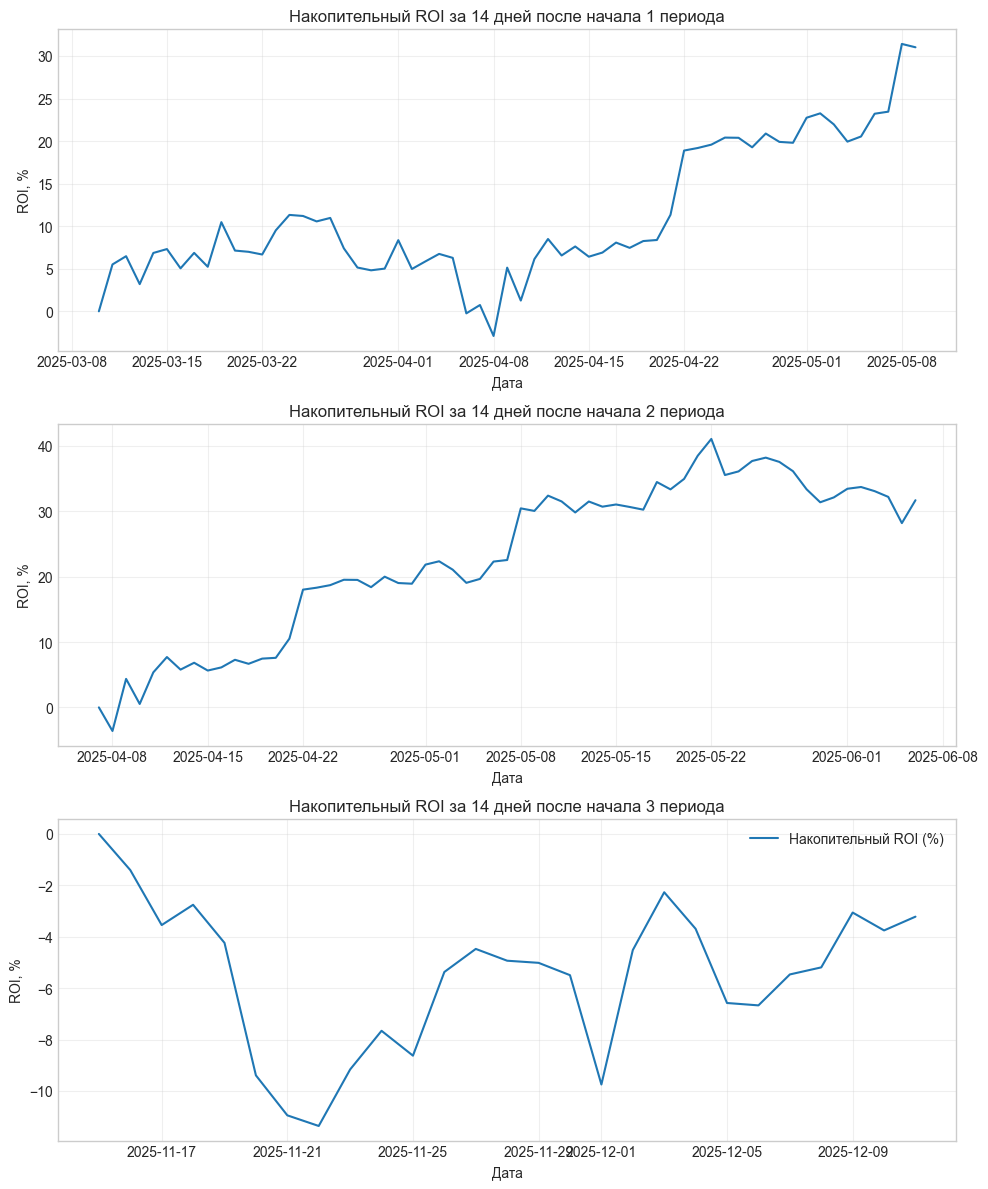

In [332]:
# Посчитаем ROI через два недели, после начала периода с низким индексом

# Возьмем даты начала каждого периода
def start_dates(periods: list, total: pd.DataFrame):
    # Функция берет на вход список датафреймов каждого периода,
    # и отсекает только момент начала периода
    start_low_index = pd.concat([
        pd.DataFrame({'period': [i + 1], 'index': period['index'].iloc[[0]]})
        for i, period in enumerate(periods)])
    total_start = pd.concat([total, start_low_index], axis=1)
    total_start = total_start.asfreq('D', method='pad').loc[:, ['close', 'period']]
    return start_low_index, total_start

def roi_periods(data1: pd.DataFrame, data2: pd.DataFrame, period=15):
    n_periods = [i for i in data1['period']]
    roi_per = []
    for i in n_periods:
        start_period = data2.query(f'period == {i}').index.min()
        end_period = start_period + pd.Timedelta(days=period)
        result = data2[start_period:end_period]
        ROI = 100 * (result.close - result.close.iloc[0]) / result.close.iloc[0]
        roi_per.append(ROI)
    
    return roi_per

# Визуализируем данные
def visual_roi(data: list):
    fig, axes = plt.subplots(len(data), 1, figsize=(10, len(data) * 4), squeeze=False)
    axes = axes.flatten()

    for i, r in enumerate(data):
        axes[i].plot(r, label='Накопительный ROI (%)')
        axes[i].set_title(f'Накопительный ROI за 14 дней после начала {i + 1} периода')
        axes[i].set_xlabel('Дата')
        axes[i].set_ylabel('ROI, %')
        axes[i].grid(True, alpha=0.3)

    plt.legend()
    plt.tight_layout()
    plt.show()

s_period, data_roi = start_dates(periods, total_2025)
ROI_all = roi_periods(s_period, data_roi, 60)
visual_roi_2025 = visual_roi(ROI_all)
visual_roi_2025

## 2024 год

In [333]:
# Проводим анализ за 2024 год

# Получаем данные: берем данные цены с биржи и данные индекса
def extract_data(session=session, date_start='2024-01-01', date_end='2025-01-02', url=URL_2):
    # Функция получает данные цен с биржи и данные индекса
    # Указываем конечную дату на 1 день больше, так как данные по закрытию приходят в 03:00 АМ
    start = int(datetime.strptime(date_start, '%Y-%m-%d').timestamp() * 1000)
    end = int(datetime.strptime(date_end, '%Y-%m-%d').timestamp() * 1000)

    response_exchange = session.get_kline(
        category='inverse',
        symbol='BTCUSDT',
        interval='D',
        start=start,
        end=end,
        limit=367
    )

    params = {
        'limit': 0
    }
    response_index = requests.get(url, params=params).json()

    return response_exchange['result']['list'], response_index['data']


# Преобразуем данные: загружаем в датафрейм
def transform_data(data1: list, data2: list):
    # Функция обрабатывает полученные данные от биржи.
    # Записывает в DataFrame.
    df = pd.DataFrame(data1, columns=['date', 'open', 'high', 'low', 'close', 'vol', 'turnover'])
    df = df.iloc[:, :6]
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index, unit='ms')
    df = df.astype('float')

    df2 = pd.DataFrame({
        'date': [i['timestamp'] for i in data2],
        'index': [i['value'] for i in data2]
    })
    df2.set_index('date', inplace=True)
    df2.index = pd.to_datetime(df2.index, unit='s')
    df2 = df2.astype('int')

    df3 = pd.concat([df, df2], axis=1, join='inner')
    rolling = df3['close'].rolling(30, min_periods=1)
    df3['roll_mean'] = rolling.mean()
    df3['roll_median'] = rolling.median()

    return df, df2, df3

def find_periods(df: pd.DataFrame):
    min_index = df.loc[df['index'] < 20].sort_index()

    # разбиваем на фрагменты
    min_index['date_diff'] = min_index.index.diff().fillna(pd.Timedelta(days=0))

    fragments = []
    current_period = [min_index.iloc[0]]

    for i in range(1, len(min_index)):
        if min_index.iloc[i]['date_diff'] > pd.Timedelta(days=20):
            fragments.append(pd.DataFrame(current_period))
            current_period = [min_index.iloc[i]]
        else:
            current_period.append(min_index.iloc[i])
    fragments.append(pd.DataFrame(current_period))

    return fragments

data_2024, index_2024 = extract_data()
df_2024, df_index, total_2024 = transform_data(data_2024, index_2024)
periods_2024 = find_periods(total_2024)

C:\Users\deadm\AppData\Local\Temp\ipykernel_18208\4292394843.py:34: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df.index = pd.to_datetime(df.index, unit='ms')
C:\Users\deadm\AppData\Local\Temp\ipykernel_18208\4292394843.py:42: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df2.index = pd.to_datetime(df2.index, unit='s')


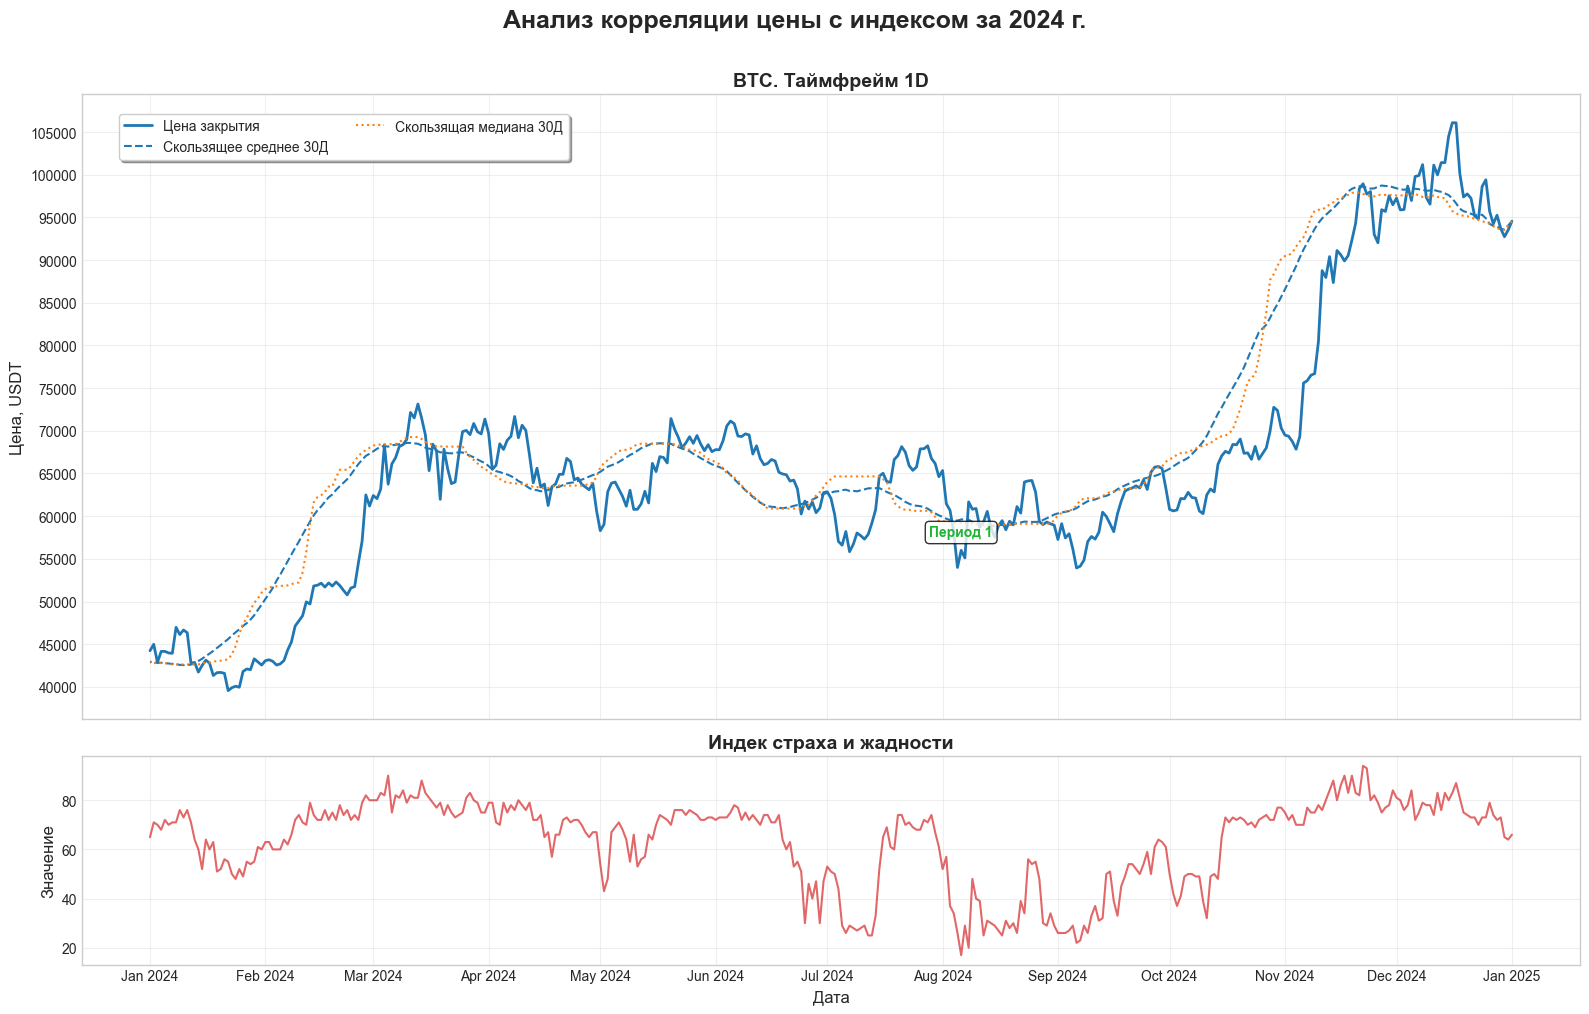

In [ ]:
# Визуализируем данные за 2024 г.

fig3, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Верхний график — цена
ax1.plot(total_2024.index, total_2024.close, color='#1f77b4', linewidth=2, label='Цена закрытия')
ax1.plot(total_2024.roll_mean, linestyle='--', linewidth=1.5, label='Скользящее среднее 30Д')
ax1.plot(total_2024.roll_median, linestyle=':', linewidth=1.5, label='Скользящая медиана 30Д')
ax1.set_title('BTC. Таймфрейм 1D', fontsize=14, fontweight='bold')
ax1.set_ylabel('Цена, USDT', fontsize=12)
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.yaxis.set_major_locator(MultipleLocator(5000))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98),
          ncol=2, frameon=True, fancybox=True, shadow=True)

# Наложение периодов низкого индекса (< 20)
for i, period in enumerate(periods_2024):
    ax1.plot(period.index, period['close'], color="#1fb433", linewidth=3, label='Индекс < 20')
    ax1.grid(True, alpha=0.3)

    # Аннотации: подпись над каждым периодом
    mid_date = period.index[len(period) // 2]  # середина периода
    mid_price = period.iloc[len(period) // 2]['close']
    ax1.annotate(f'Период {i+1}',
                xy=(mid_date, mid_price),
                xytext=(0, 10),  # смещение вверх на 10 пунктов
                textcoords='offset points',
                fontsize=10,
                fontweight='bold',
                color='#1fb433',
                ha='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))


# Нижний график — индекс
ax2.plot(total_2024['index'], color='#d62728', alpha=0.7, linewidth=1.5, label='Индекс')
ax2.set_title('Индек страха и жадности', fontsize=14, fontweight='bold')
ax2.set_ylabel('Значение', fontsize=12)
ax2.set_xlabel('Дата', fontsize=12)
ax2.grid(True, alpha=0.3)

fig3.suptitle(
    'Анализ корреляции цены с индексом за 2024 г.',
    fontsize=18,
    fontweight='bold',
    y = 1.01
)


plt.tight_layout()
plt.show()

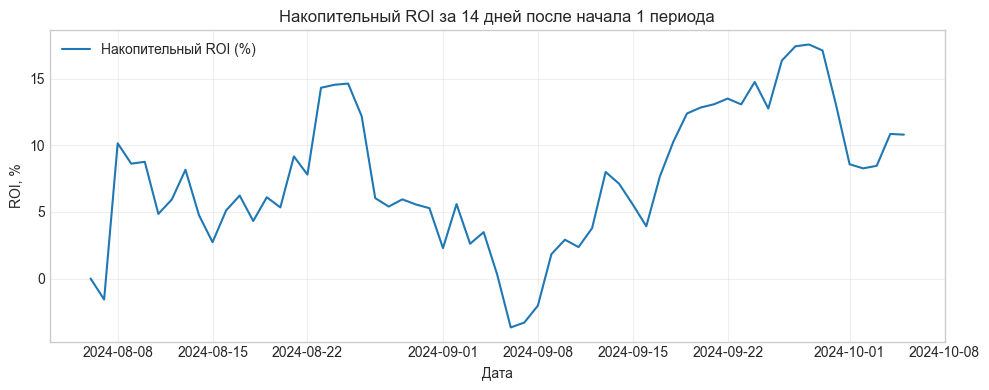

In [325]:
# Посчитаем ROI через два недели, после начала периода с низким индексом

s_period, data_roi = start_dates(periods_2024, total_2024)
ROI_all = roi_periods(s_period, data_roi, 60)
visual_roi_2024 = visual_roi(ROI_all)
visual_roi_2024